In [1]:
__author__ = "Philipp Kats"
__date__ = "2015_10_15"

import pandas as pd
import numpy as np

import pylab as plt
import os
import json

import requests
s = requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
plt.rcParams.update(s)

import geopandas as gp
from geopandas.tools import sjoin
from shapely.geometry import Point

%pylab inline

/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
PARQA = os.getenv('PARQA') #basic path

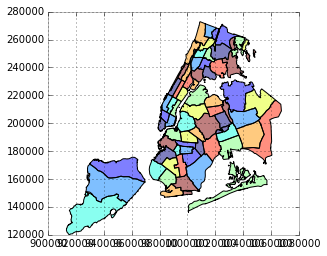

In [21]:
## read districts
Districts = gp.read_file( PARQA + 'data/shp/ParkDistrict.shp')
Districts.plot()


In [4]:
Districts.head(2)

,ACRES,BOROUGH,COMMUNITYB,COUNCILDIS,SHAPE_Area,SHAPE_Leng,SYSTEM,geometry
0,None,M,101,"3, 1",32993723.208838,41661.646039,M-01,"POLYGON ((979362.7820722163 195771.7118528038,..."
1,None,M,102,"3, 1, 2",37682859.456715,33897.229525,M-02,"POLYGON ((981041.1455133855 203852.925677225, ..."


In [3]:
## Now read park complains

calls = pd.read_csv( PARQA + 'data/2015_10_9_311_parks.csv')


/Users/casy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (18,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
len(calls)

66395

In [5]:
calls.columns

Index([u'Unnamed: 0', u'Unique Key', u'Created Date', u'Closed Date',
       u'Agency', u'Agency Name', u'Complaint Type', u'Descriptor',
       u'Location Type', u'Incident Zip', u'Incident Address', u'Street Name',
       u'Cross Street 1', u'Cross Street 2', u'Intersection Street 1',
       u'Intersection Street 2', u'Address Type', u'City', u'Landmark',
       u'Facility Type', u'Status', u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction'

In [6]:
print 100.0 * len(calls[pd.isnull(calls.Latitude)])/len(calls), 'Percent not geolocated'


77.4440846449 Percent not geolocated


Lets then locate by park

In [7]:
len(calls[pd.isnull(calls['Incident Address'])])

51797

In [37]:
parks = gp.read_file(PARQA + 'data/parks_computed.geojson')

In [41]:
parks.columns

Index([      u'BOROUGH',    u'GISPROPNUM',      u'LOCATION',    u'NYS_ASSEMB',
          u'NYS_SENATE', u'Park_District',    u'SHAPE_STAr',    u'SHAPE_STLe',
            u'SIGNNAME',    u'TYPECATEGO',    u'US_CONGRES',    u'WATERFRONT',
            u'geometry',            u'id',     u'park_area'],
      dtype='object')

In [49]:
parks.SIGNNAME.value_counts()

Park                                   124
Garden                                  14
Brooklyn Heights Promenade              10
LaGuardia Landing Lights                 6
Harlem River Park                        5
Sitting Area                             4
Broadway Malls                           4
Lot                                      4
Spring Creek Park                        3
Triangle                                 3
Park Avenue Malls                        3
St. Mary's Park                          3
Victory Garden                           3
Riverside Park                           2
Laguardia Landing Lights                 2
Classon Playground                       2
Kelly Park                               2
Bridge Park                              2
Lafayette Playground                     2
Hillside Park                            2
Bushwick Playground                      2
Family Community Garden                  2
Kissena Corridor Park                    2
Rainey Park

In [43]:
calls['Park Facility Name'].value_counts()

Central Park                                                          2487
Riverside Park                                                        1186
Prospect Park                                                          930
Rockaway Beach Boardwalk                                               754
Flushing Meadows Corona Park                                           722
Beach - Brighton                                                       595
Hudson River Park                                                      484
Morningside Park                                                       430
Tompkins Square Park                                                   403
Marine Park                                                            400
Forest Park                                                            399
Van Cortlandt Park                                                     362
Washington Square Park                                                 361
Mccarren Park            

In [44]:
calls2 = calls.merge(, parks, how='left', left_on='Park Facility Name', right_on='SIGNNAME')

In [45]:
calls2.columns

Index([                    u'Unnamed: 0',                     u'Unique Key',
                         u'Created Date',                    u'Closed Date',
                               u'Agency',                    u'Agency Name',
                       u'Complaint Type',                     u'Descriptor',
                        u'Location Type',                   u'Incident Zip',
                     u'Incident Address',                    u'Street Name',
                       u'Cross Street 1',                 u'Cross Street 2',
                u'Intersection Street 1',          u'Intersection Street 2',
                         u'Address Type',                           u'City',
                             u'Landmark',                  u'Facility Type',
                               u'Status',                       u'Due Date',
               u'Resolution Description', u'Resolution Action Updated Date',
                      u'Community Board',                        u'Borough',

In [51]:
unrecognised = calls2[pd.isnull(calls2['geometry'])]
print len(unrecognised)
print unrecognised['Park Facility Name'].value_counts()


35374
Beach - Brighton                                                         595
Hudson River Park                                                        484
Mccarren Park                                                            348
East River Park                                                          325
Inwood Hill Park - Nature Center                                         296
St Nicholas Park                                                         273
Jackie Robinson Park - Playground One Fifty Two Clii                     184
Randalls Island Park                                                     181
Sara D Roosevelt Park                                                    180
Underhill Playground - Brooklyn                                          170
Beach - Orchard                                                          170
Inwood Hill Park - Indian Road Playground                                156
J Hood Wright Park                                                    

In [52]:
pd.DataFrame(unrecognised['Park Facility Name'].value_counts()).to_csv(PARQA + 'data/311_unrecoginsed_parks.csv')

## BELOW: not working

In [19]:
# calls to geofataframe to perform spatial join
calls['geometry'] = calls.apply(lambda z: Point(z['X Coordinate (State Plane)'], z['Y Coordinate (State Plane)']), axis=1)
calls = gp.GeoDataFrame(calls)

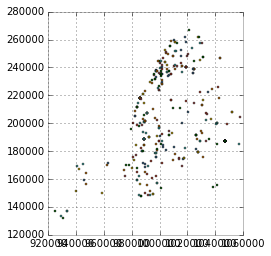

In [20]:
calls.iloc[:2000,:].plot() # check-check

In [11]:
calls.crs = {'ellps':'WGS84', 'datum':'WGS84', 'proj':'longlat'}

In [22]:
crs = Districts.crs
calls.crs = crs


In [15]:
/Districts.crs = {'ellps': 'WGS84', 'datum': 'WGS84', 'proj': 'longlat'}

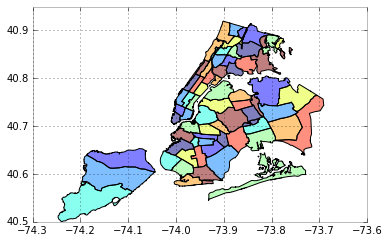

In [16]:
# plt.figure()

# calls.iloc[:4000,:].plot()
Districts.plot()

In [13]:
print calls.crs
print Districts.crs

{'ellps': 'WGS84', 'datum': 'WGS84', 'proj': 'longlat'}
{'init': 'epsg:4236', 'no_defs': True}


In [76]:
### lets save and open dataframes, mabe that can help
def writeJson(df,path):
    '''writes df as json'''
    with open(path,'w') as jsFile:
        jsFile.write(df.to_json())

In [ ]:
calls[['geometry','Unique Key']].to_file(PARQA+'data/calls_tmp.shp')

In [80]:
writeJson( calls[['geometry','Unique Key']], PARQA+'data/calls_tmp.geojson')
writeJson( Districts,PARQA+'data/Districts_tmp.geojson')

In [81]:
calls1 = gp.read_file(PARQA+'data/calls_tmp.geojson')

IOError: Failed to read GeoJSON data

In [72]:
districts1=gp.read_file(PARQA + 'data/Districts_tmp.geojson')

In [23]:
calls = sjoin(calls, Districts, how="left")
calls.head(5)

RTreeError: Coordinates must not have minimums more than maximums

## II. Now lets get total complains per district

In [16]:
# SYSTEM
# Districts['calls'] = calls[['Park Borough', ]].groupby('Park Borough')


0        MANHATTAN
1         BROOKLYN
2    STATEN ISLAND
3         BROOKLYN
4         BROOKLYN
Name: Park Borough, dtype: object